In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from helpers import combine_position_data, log, load_csv, save_csv, calculate_season_average_until_gw
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import root_mean_squared_error, r2_score

In [3]:
data_directory = "Fantasy-Premier-League/data"
seasons = ["2022-23", "2023-24", "2024-25"]
positions = ["DEF", "MID", "FWD"]
output_file_name = "ga_training_data.csv"

log("Combining position data...", level="INFO")
combine_position_data(data_directory, seasons, positions, output_file_name)

INFO: Combining position data...
INFO: Loaded data from DEF_players.csv for season 2022-23.
INFO: Loaded data from MID_players.csv for season 2022-23.
INFO: Loaded data from FWD_players.csv for season 2022-23.
INFO: Loaded data from DEF_players.csv for season 2023-24.
INFO: Loaded data from MID_players.csv for season 2023-24.
INFO: Loaded data from FWD_players.csv for season 2023-24.
INFO: Loaded data from DEF_players.csv for season 2024-25.
INFO: Loaded data from MID_players.csv for season 2024-25.
INFO: Loaded data from FWD_players.csv for season 2024-25.
INFO: Saved CSV: Fantasy-Premier-League/data/training_data/ga_training_data.csv
INFO: Combined data saved to Fantasy-Premier-League/data/training_data/ga_training_data.csv.


INFO: Applying feature engineering...
Sample of X_train (features):
       value  opponent_defense  own_attack  rolling_xg_5  average_xg_season
29233     55              1040        1210         0.010           0.060769
1826      52              1090        1220         0.046           0.130000
20669     72              1120        1340         0.214           0.178333
6943      74              1220        1100         0.670           0.578889
12803     50              1320        1020         0.040           0.000000
INFO: Training model...
INFO: RMSE: 0.1828565751986786
INFO: R-squared: 0.5133387149258415
INFO: Plotting feature importance...


<Figure size 1000x800 with 0 Axes>

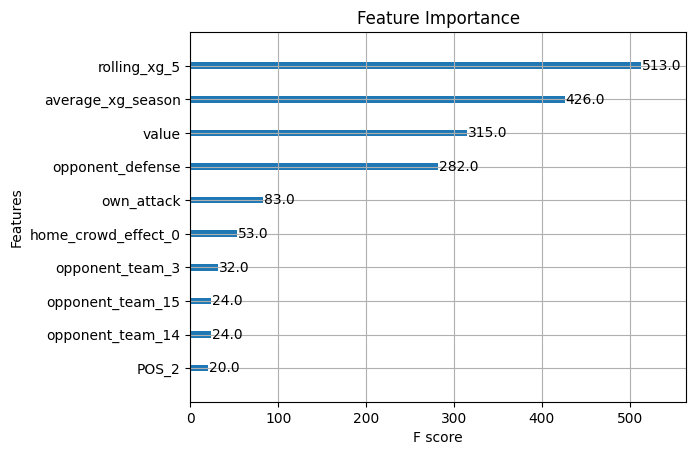

INFO: Model saved at: models/xgboost_xg_prediction_model.json


In [4]:
training_data_dir = os.path.join(data_directory, "training_data")
training_file = os.path.join(training_data_dir, output_file_name)
data = load_csv(training_file)
if data is None:
    log("Failed to load training data. Exiting.", level="ERROR")
    exit()

# ========================
# Feature Engineering
# ========================
log("Applying feature engineering...", level="INFO")
MIN_MINUTES = 60

data = data[data['minutes'] >= MIN_MINUTES]

# Remove gameweek 1 from data
data = data[data['gameweek'] > 1]

data['was_home'] = data['was_home'].astype(int)
data['home_crowd_effect'] = data['was_home'] * data['crowds']
data = data.sort_values(by=["unique_id", "season", "gameweek"])

data['rolling_xg_5'] = data.groupby('unique_id')['expected_goals'].rolling(window=5, min_periods=1).mean().reset_index(0, drop=True)

data['average_xg_season'] = calculate_season_average_until_gw(
    data=data,
    value_column='expected_goals',
    group_columns=['unique_id', 'season'],
    current_column='gameweek'
)

# One-hot encoding for categorical features
dummy_columns = ["POS", "home_crowd_effect", "unique_id", "own_team", "opponent_team"]
data = pd.get_dummies(data, columns=dummy_columns)

# Define features
numerical_features = [
    "value", "opponent_defense", "own_attack",
    "rolling_xg_5", "average_xg_season"
]
categorical_features = [
    col for col in data.columns if any(col.startswith(f"{dummy_col}_") for dummy_col in dummy_columns)
]
features = numerical_features + categorical_features

TARGET_COLUMN = "expected_goals"
X = data[features]
y = data[TARGET_COLUMN]

# ========================
# Train-Test Split
# ========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Sample of X_train (features):")
print(X_train[numerical_features].head())


# ========================
# Model Training
# ========================
def train_model(X_train, y_train, X_test, y_test):
    log("Training model...", level="INFO")
    try:
        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        log(f"RMSE: {rmse}", level="INFO")
        log(f"R-squared: {r2}", level="INFO")
        return model
    except Exception as e:
        log(f"Error during model training: {e}", level="ERROR")
        raise

model = train_model(X_train, y_train, X_test, y_test)

# ========================
# Feature Importance
# ========================
log("Plotting feature importance...", level="INFO")
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10, importance_type="weight")
plt.title("Feature Importance")
plt.show()

# ========================
# Save Model
# ========================
models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "xgboost_xg_prediction_model.json")
model.save_model(model_path)
log(f"Model saved at: {model_path}", level="INFO")

# ========================
# Optional Hyperparameter Tuning
# ========================
def hyperparameter_tuning(X_train, y_train):
    from sklearn.model_selection import GridSearchCV

    log("Starting hyperparameter tuning...", level="INFO")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    model = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    log(f"Best parameters found: {grid_search.best_params_}", level="INFO")
    log(f"Best RMSE: {-grid_search.best_score_}", level="INFO")
    return grid_search.best_estimator_

# Uncomment to perform tuning
# best_model = hyperparameter_tuning(X_train, y_train)

INFO: Applying feature engineering...
Sample of X_train (features):
       value  opponent_defense  own_attack  rolling_xa_5  average_xa_season
29233     55              1040        1210         0.062           0.093846
1826      52              1090        1220         0.016           0.074286
20669     72              1120        1340         0.322           0.225000
6943      74              1220        1100         0.046           0.100000
12803     50              1320        1020         0.005           0.000000
INFO: Training model...
INFO: RMSE: 0.09829852820341456
INFO: R-squared: 0.49277485641329954
INFO: Plotting feature importance...


<Figure size 1000x800 with 0 Axes>

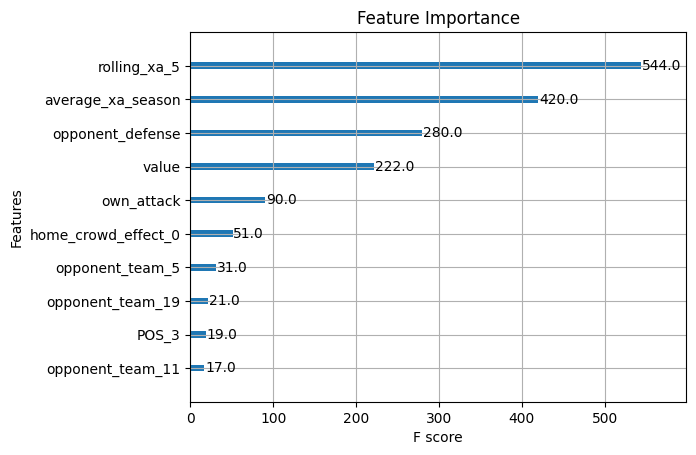

INFO: Model saved at: models/xgboost_xa_prediction_model.json


In [5]:
training_data_dir = os.path.join(data_directory, "training_data")
training_file = os.path.join(training_data_dir, output_file_name)
data = load_csv(training_file)
if data is None:
    log("Failed to load training data. Exiting.", level="ERROR")
    exit()

# ========================
# Feature Engineering
# ========================
log("Applying feature engineering...", level="INFO")
MIN_MINUTES = 60

data = data[data['minutes'] >= MIN_MINUTES]

# Remove gameweek 1 from data
data = data[data['gameweek'] > 1]

data['was_home'] = data['was_home'].astype(int)
data['home_crowd_effect'] = data['was_home'] * data['crowds']
data = data.sort_values(by=["unique_id", "season", "gameweek"])

data['rolling_xa_5'] = data.groupby('unique_id')['expected_assists'].rolling(window=5, min_periods=1).mean().reset_index(0, drop=True)

data['average_xa_season'] = calculate_season_average_until_gw(
    data=data,
    value_column='expected_assists',
    group_columns=['unique_id', 'season'],
    current_column='gameweek'
)

# One-hot encoding for categorical features
dummy_columns = ["POS", "home_crowd_effect", "unique_id", "own_team", "opponent_team"]
data = pd.get_dummies(data, columns=dummy_columns)

# Define features
numerical_features = [
    "value", "opponent_defense", "own_attack",
    "rolling_xa_5", "average_xa_season"
]
categorical_features = [
    col for col in data.columns if any(col.startswith(f"{dummy_col}_") for dummy_col in dummy_columns)
]
features = numerical_features + categorical_features

TARGET_COLUMN = "expected_assists"
X = data[features]
y = data[TARGET_COLUMN]

# ========================
# Train-Test Split
# ========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Sample of X_train (features):")
print(X_train[numerical_features].head())

# ========================
# Model Training
# ========================
def train_model(X_train, y_train, X_test, y_test):
    log("Training model...", level="INFO")
    try:
        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        log(f"RMSE: {rmse}", level="INFO")
        log(f"R-squared: {r2}", level="INFO")
        return model
    except Exception as e:
        log(f"Error during model training: {e}", level="ERROR")
        raise

model = train_model(X_train, y_train, X_test, y_test)

# ========================
# Feature Importance
# ========================
log("Plotting feature importance...", level="INFO")
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10, importance_type="weight")
plt.title("Feature Importance")
plt.show()

# ========================
# Save Model
# ========================
models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "xgboost_xa_prediction_model.json")
model.save_model(model_path)
log(f"Model saved at: {model_path}", level="INFO")

# ========================
# Optional Hyperparameter Tuning
# ========================
def hyperparameter_tuning(X_train, y_train):
    from sklearn.model_selection import GridSearchCV

    log("Starting hyperparameter tuning...", level="INFO")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    model = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    log(f"Best parameters found: {grid_search.best_params_}", level="INFO")
    log(f"Best RMSE: {-grid_search.best_score_}", level="INFO")
    return grid_search.best_estimator_

# Uncomment to perform tuning
# best_model = hyperparameter_tuning(X_train, y_train)